# Project

In [56]:
# to have plots with time, set  EPOCHS=99999 and MAX_RUNTIME=60, PLOT_TIME = True
# to have plots with iters, set EPOCHS=20 and MAX_RUNTIME=999999999, PLOT_TIME = False
PLOT_TIME = True
EPOCHS = 99999999999999999
ITERS_PER_BATCH = 40
MINI_BATCH_SIZE = 256
MAX_RUNTIME = 60
SAME_MINI_BATCH = True
LEARNING_RATE_DECAY = {
    "SGD": 0.9995,
    "SAG": 0.9999,
    "SAGA": 0.9999,
    "SVGR": 0.9999,
    "SARAH": 0.9999,
    "SARAH+": 0.9999,
    "SpiderBoost": 0.9999,
    "SNVRG": 0.9999,
} if PLOT_TIME else {
    "SGD": 0.996,
    "SAG": 0.996,
    "SAGA": 0.996,
    "SVGR": 0.996,
    "SARAH": 0.996,
    "SARAH+": 0.996,
    "SpiderBoost": 0.996,
    "SNVRG": 0.996,
}
DPI_PLOTS = 200
FRAME_ANIMATION = 300
DOWNLOAD_AND_STORE = False
SHOW_ANIMATION = False
# one from:
# - "mse",
# - "robust_lin_reg",
# - "cross_entropy_regularized"
LOSS = "robust_lin_reg"
# one from:
# - mnist
# - cat-vs-dog
# - bio-or-not
# - fish-or-not
DATASET = "cat-vs-dog"

## Dataset

In [2]:
from tensorflow import keras
import matplotlib.pyplot as plt
import math
import tensorflow as tf
import numpy as np
import os
import time
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [3]:
def decode_image(image_file_names, FINAL_SIZE, PAD_CROP_SIZE):
    images = []
    for image_path in image_file_names:
        image = np.array(Image.open(image_path))
        if len(image.shape) < 3:
            image = np.repeat(image[:, :, np.newaxis], 3, axis=2)
        try:
            images.append(
                tf.image.rgb_to_grayscale(
                    tf.image.resize(
                        tf.image.resize_with_crop_or_pad(image, PAD_CROP_SIZE, PAD_CROP_SIZE),
                        (FINAL_SIZE, FINAL_SIZE)
                    )
                )
            )
        except:
            print("Error loading:", image_path)
    return images

In [4]:
if SHOW_ANIMATION:
    LOSS = "cross_entropy_regularized"
    DATASET = "cat-vs-dog"
    PLOT_TIME = True
    MAX_RUNTIME = max(15, MAX_RUNTIME)
    FRAME_ANIMATION = max(MAX_RUNTIME, FRAME_ANIMATION)
    #MINI_BATCH_SIZE = 1024

In [5]:
if DATASET == "mnist":
    (x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
    data = np.concatenate((x_train, x_test))
    targets = np.concatenate((y_train, y_test)).astype("int")
    data = data[np.logical_or(targets == 0, targets == 1)]
    targets = targets[np.logical_or(targets == 0, targets == 1)]
    data = PCA(n_components=2).fit_transform(MinMaxScaler().fit_transform(data.reshape((data.shape[0], -1))))
elif DATASET == "cat-vs-dog":
    if DOWNLOAD_AND_STORE:
        DATA_DIR = "datasets/cat-vs-dog/"
        SIZE = 100
        PAD_CROP_SIZE = 500
        print("Locating images 'cats or dog'")
        cats_train_image_file_names = [DATA_DIR+"cat/"+i for i in sorted(os.listdir(DATA_DIR+"cat")) if not i.startswith(".")][0:7000]
        dogs_train_image_file_names = [DATA_DIR+"dog/"+i for i in sorted(os.listdir(DATA_DIR+"dog")) if not i.startswith(".")][0:7000]
        print("Loading images")
        cats = np.array(decode_image(cats_train_image_file_names, SIZE, PAD_CROP_SIZE))
        dogs = np.array(decode_image(dogs_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        data = np.concatenate((cats, dogs)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(cats)), np.ones(len(dogs))))
        data = data[shuffle]
        targets = targets[shuffle]
        plt.imshow(1-cats[3].reshape((SIZE, SIZE)), cmap="gray")
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=300).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        with open('datasets/cat-vs-dog/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/cat-vs-dog/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        print("Loading from cached file 'cats or dog'")
        with open('datasets/cat-vs-dog/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/cat-vs-dog/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)
elif DATASET == "bio-or-not":
    if DOWNLOAD_AND_STORE:
        DATA_DIR = "datasets/bio-or-not/"
        SIZE = 100
        PAD_CROP_SIZE = 200
        print("Locating images 'bio or not'")
        bio_train_image_file_names = [DATA_DIR+"bio/"+i for i in sorted(os.listdir(DATA_DIR+"bio")) if not i.startswith(".")][0:7000]
        not_train_image_file_names = [DATA_DIR+"not/"+i for i in sorted(os.listdir(DATA_DIR+"not")) if not i.startswith(".")][0:7000]
        print("Loading images")
        bios = np.array(decode_image(bio_train_image_file_names, SIZE, PAD_CROP_SIZE))
        nots = np.array(decode_image(not_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        data = np.concatenate((bios, nots)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(bios)), np.ones(len(nots))))
        data = data[shuffle]
        targets = targets[shuffle]
        plt.imshow(1-bios[3].reshape((SIZE, SIZE)), cmap="gray")
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=300).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        with open('datasets/bio-or-not/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/bio-or-not/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        print("Loading from cached file 'bio or not'")
        with open('datasets/bio-or-not/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/bio-or-not/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)
elif DATASET == "fish-or-not":
    if DOWNLOAD_AND_STORE:
        DATA_DIR = "datasets/fish-or-not/"
        SIZE = 100
        PAD_CROP_SIZE = 500
        print("Locating images 'fish or not'")
        fish_train_image_file_names = [DATA_DIR+"fish/"+i for i in sorted(os.listdir(DATA_DIR+"fish")) if not i.startswith(".")][0:7000]
        not_train_image_file_names = [DATA_DIR+"not/"+i for i in sorted(os.listdir(DATA_DIR+"not")) if not i.startswith(".")][0:7000]
        print("Loading images")
        fishes = np.array(decode_image(fish_train_image_file_names, SIZE, PAD_CROP_SIZE))
        nots = np.array(decode_image(not_train_image_file_names, SIZE, PAD_CROP_SIZE))
        print("Shuffling images")
        data = np.concatenate((fishes, nots)).reshape((-1, SIZE*SIZE))
        shuffle = np.random.permutation(list(range(0, len(data))))
        targets = np.concatenate((np.zeros(len(fishes)), np.ones(len(nots))))
        data = data[shuffle]
        targets = targets[shuffle]
        plt.imshow(1-fishes[3].reshape((SIZE, SIZE)), cmap="gray")
        print("Applying PCA")
        data = MinMaxScaler().fit_transform(PCA(n_components=1000).fit_transform(data.reshape((data.shape[0], -1))))
        print("Saving in filesystem")
        with open('datasets/fish-or-not/loaded-rescaled-data.npy', 'wb') as f:
            np.save(f, data)
        with open('datasets/fish-or-not/loaded-rescaled-targets.npy', 'wb') as f:
            np.save(f, targets)
    else:
        print("Loading from cached file 'fish or not'")
        with open('datasets/fish-or-not/loaded-rescaled-data.npy', 'rb') as f:
            data = np.load(f)
        with open('datasets/fish-or-not/loaded-rescaled-targets.npy', 'rb') as f:
            targets = np.load(f)

Loading from cached file 'cats or dog'


In [6]:
starting_point = {
    "cat-vs-dog": {
        "robust_lin_reg": np.zeros(data.shape[1]),
        "mse": np.zeros(data.shape[1])+ 0.1,
        "cross_entropy_regularized": np.zeros(data.shape[1]) + 0.01,
    },
    "bio-or-not": {
        "robust_lin_reg": np.zeros(data.shape[1]),
        "mse": np.zeros(data.shape[1]),
        "cross_entropy_regularized": np.zeros(data.shape[1]) + 0.01,
    },
    "fish-or-not": {
        "robust_lin_reg": np.zeros(data.shape[1]),
        "mse": np.zeros(data.shape[1]),
        "cross_entropy_regularized": np.zeros(data.shape[1]) + 0.01,
    }
}[DATASET][LOSS]

In [7]:
MIN = {
    "cat-vs-dog":{
        "mse": 1,
        "robust_lin_reg": 0.1119473612180889,
        "cross_entropy_regularized": 0.6928701583010055,
    },
    "bio-or-not":{
        "mse": 1,
        "robust_lin_reg": 0.07250611336253084,
        "cross_entropy_regularized": 0.686974374546113,
    },
    "fish-or-not":{
        "mse": 1,
        "robust_lin_reg": 0.01751466441643479,
        "cross_entropy_regularized": 0.26535480270464623,
    }
}[DATASET][LOSS]

In [8]:
if SHOW_ANIMATION:
    indexes = np.random.choice(list(range(len(data))), MINI_BATCH_SIZE*12)
    data = data[indexes]
    targets = targets[indexes]#[:MINI_BATCH_SIZE]
    starting_point = np.array([12,12])
    data = MinMaxScaler().fit_transform(PCA(n_components=2).fit_transform(data))#[:MINI_BATCH_SIZE]

## Loss & Grad

In [9]:
#MIN SQUARE ERROR (CONVEX)
def loss_mse(data, targets, w):
    return np.square(data@w - targets).mean()
def grad_mse_array(data, params, targets):
    return -1 / data.shape[0] * data.T @ (targets - data @ params)
def grad_mse_single(sample, params, target):
    return -1 * (target - sample @ params) * sample


# ROBUST LINEAR REGRESSION (NON CONVEX)
def loss_robust_lin_reg(data, targets, w):
    return np.log(1e-10 + np.square(targets - data@w)/2 + 1).mean()
def grad_robust_lin_reg_single(sample, w, target):
    return 1/(1e-10 + (target - sample@w)**2 / 2 + 1) * (target - sample@w) * -sample
def grad_robust_lin_reg_array(data, w, targets):
    return (1/
            (1e-10 + (targets - data@w)**2 / 2 + 1) *
            (targets - data@w) @
            -data)/ data.shape[0]


# CROSS ENTROPY WITH REGULARIZER (NON CONVEX)
alpha = 1/10
def loss_cross_entropy_regularized(data, targets, w):
    return (
                   -np.log(1e-10 + 1/(1+ np.exp(-np.dot(data, w).astype("float64")))) * targets
                   -np.log(1e-10 + 1 - 1/(1+ np.exp(-np.dot(data, w).astype("float64")))) * (1-targets)
           ).mean() + \
           (w**2 / (w**2 + 1)).sum() * alpha
def grad_cross_entropy_regularized_single(sample, w, target):
    return (-target * np.exp(-np.dot(sample, w)) + (1-target)) / (1 + np.exp(-np.dot(sample, w)) + 1e-10) * sample + 2*w / (w**2 + 1)**2 * alpha
def grad_cross_entropy_regularized_array(data, w, targets):
    return ((-targets * np.exp(-np.dot(data, w)) + (1-targets)) /
             (1 + np.exp(-np.dot(data, w)) + 1e-10) @ data) / data.shape[0] + (2*w / (w**2 + 1)**2) * alpha

assert LOSS in ["mse", "robust_lin_reg", "cross_entropy_regularized"]
# PROXY
def loss(data, w, targets):
    if LOSS == "robust_lin_reg":
        return loss_robust_lin_reg(data, targets, w)
    elif LOSS == "mse":
        return loss_mse(data, targets, w)
    elif LOSS == "cross_entropy_regularized":
        return loss_cross_entropy_regularized(data, targets, w)
def grad_single(sample, w, target):
    if LOSS == "robust_lin_reg":
        return grad_robust_lin_reg_single(sample, w, target)
    elif LOSS == "mse":
        return grad_mse_single(sample, w, target)
    elif LOSS == "cross_entropy_regularized":
        return grad_cross_entropy_regularized_single(sample, w, target)
def grad_array(data, w, targets):
    if LOSS == "robust_lin_reg":
        return grad_robust_lin_reg_array(data, w, targets)
    elif LOSS == "mse":
        return grad_mse_array(data, w, targets)
    elif LOSS == "cross_entropy_regularized":
        return grad_cross_entropy_regularized_array(data, w, targets)

In [10]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    starting_point = np.array([40, 80])
    x = np.linspace(-5,50, 100)
    y = np.linspace(-5,90, 100)
    X, Y = np.meshgrid(x, y)
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    fig = go.Figure(data=[
        go.Scatter3d(
            name="Starting point",
            x=[starting_point[0]], y=[starting_point[1]], z=[loss(data, starting_point, targets)],
            marker=dict(
                size=5,
                color="red",
                colorscale='Viridis',
            ),
        ),
        go.Surface(
            showscale=False,
            z=Z, x=X, y=Y,
            colorscale="Viridis",
            colorbar=None
        ),
    ], )
    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)

    fig.update_layout(
        width=1600,height=1200,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
    )
    fig.show(renderer="browser")

## Stepsizes

In [64]:
# USING PCA TOP 300
# Starting from [1,1,...,1]
STEP_SIZES = {
    "mnist": {
        "mse": {
            "SGD": 0.01,
            "SAG": 0.0005,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.01,
            "SpiderBoost": 0.05,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.08,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVGR": 0.01,
            "SARAH": 0.005,
            "SARAH+": 0.005,
            "SpiderBoost": 0.5,
            "SNVRG": 0.5,
        },
        "cross_entropy_regularized": {
            "SGD": 0.1,
            "SAG": 0.01,
            "SAGA": 0.01,
            "SVGR": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.05,
            "SpiderBoost": 0.5,
            "SNVRG": 0.5,
        }
    },
    "cat-vs-dog": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.0001,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.02,
            "SNVRG": 10,
        },
        "robust_lin_reg": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVGR": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.01,
            "SpiderBoost": 0.01,
            "SNVRG": 5,
        },
        "cross_entropy_regularized": {
            "SGD": 0.0001 / 25,
            "SAG": 0.0001 / 25,
            "SAGA": 0.0002 / 25,
            "SVGR": 0.0005 / 100,
            "SARAH": 0.001 / 100,
            "SARAH+": 0.001 / 100,
            "SpiderBoost": 0.001 / 50,
            "SNVRG": 10 * 100,
        }
    },
    "bio-or-not": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.001,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.01,
            "SVGR": 0.005,
            "SARAH": 0.005,
            "SARAH+": 0.005,
            "SpiderBoost": 0.05,
            "SNVRG": 2,
        },
        "cross_entropy_regularized": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.01,
            "SNVRG": 10,
        }
    },
    "fish-or-not": {
        "mse": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.001,
            "SVGR": 0.001,
            "SARAH": 0.001,
            "SARAH+": 0.001,
            "SpiderBoost": 0.001,
            "SNVRG": 1,
        },
        "robust_lin_reg": {
            "SGD": 0.002,
            "SAG": 0.0001,
            "SAGA": 0.01,
            "SVGR": 0.01,
            "SARAH": 0.01,
            "SARAH+": 0.01,
            "SpiderBoost": 0.01,
            "SNVRG": 10,
        },
        "cross_entropy_regularized": {
            "SGD": 0.001,
            "SAG": 0.001,
            "SAGA": 0.01,
            "SVGR": 0.05,
            "SARAH": 0.2,
            "SARAH+": 0.2,
            "SpiderBoost": 0.6,
            "SNVRG": 1,
        }
    }
}

In [65]:
if SHOW_ANIMATION:
    STEP_SIZES = {
        "cat-vs-dog": {
            "cross_entropy_regularized" : {
                "SGD": 0.1,
                "SAG": 0.2,
                "SAGA": 0.2,
                "SVGR": 0.5,
                "SARAH": 0.2,
                "SARAH+": 0.2,
                "SpiderBoost": 0.7,
                "SNVRG": 0.5,
            }
        }
    }
    LEARNING_RATE_DECAY = {
        "SGD": 0.9999,
        "SAG": 0.9999,
        "SAGA": 0.9999,
        "SVGR": 0.996,
        "SARAH": 0.996,
        "SARAH+": 0.996,
        "SpiderBoost": 0.9999,
        "SNVRG": 0.9995,
    }

In [66]:
def getMiniBatch():
    if SHOW_ANIMATION:
        return np.array([data]), np.array([targets])
    c_d = []
    c_t = []
    for i in range(data.shape[0] // MINI_BATCH_SIZE):
        indexes = np.random.choice(list(range(data.shape[0])), MINI_BATCH_SIZE, replace=False)
        c_d.append(data[indexes])
        c_t.append(targets[indexes])
    return np.array(c_d), np.array(c_t)

In [67]:
def unit_vector(vector):
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## SGD

In [68]:
%%time
w = np.copy(starting_point)
track_loss_sgd = [loss(data, w, targets)]
track_time_sgd = [0]
track_angle_sgd = []
track_grad_sgd = []
track_w_sgd = [w]
track_all_w_sgd = [starting_point]
time_counter = time.time()
start =  time.time()
step = STEP_SIZES[DATASET][LOSS]["SGD"]
decay = LEARNING_RATE_DECAY["SGD"]
grad_prev = None

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                index = np.random.randint(0, c_data.shape[0])
                grad = grad_single(c_data[index], w, c_targets[index])
                w = w - step * grad
                if grad_prev is not None:
                    track_angle_sgd.append(angle_between(grad, grad_prev))
                grad_prev = grad
                step *= decay
                track_all_w_sgd.append(w)
                track_grad_sgd.append(grad)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sgd.append(w)
        track_time_sgd.append(time.time() - start)
        track_loss_sgd.append(loss(data, w, targets))

CPU times: user 2min 15s, sys: 5min 44s, total: 8min
Wall time: 1min


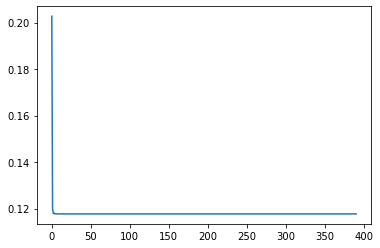

In [69]:
plt.plot(track_loss_sgd)

## SAG

In [70]:
%%time
w = np.copy(starting_point)
track_loss_sag = [loss(data, w, targets)]
start =  time.time()
track_w_sag = [w]
time_counter = time.time()
track_time_sag = [0]
step = STEP_SIZES[DATASET][LOSS]["SAG"]
decay = LEARNING_RATE_DECAY["SAG"]

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            g = np.array([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])])
            for _ in range(ITERS_PER_BATCH):
                index = np.random.randint(0, c_data.shape[0])
                g[index] = grad_single(c_data[index], w, c_targets[index])
                grad = np.mean(g, axis=0)
                w = w - step * grad

                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sag.append(w)
                step *= decay
        track_time_sag.append(time.time() - start)
        track_loss_sag.append(loss(data, w, targets))

CPU times: user 2min 9s, sys: 6min 29s, total: 8min 39s
Wall time: 1min


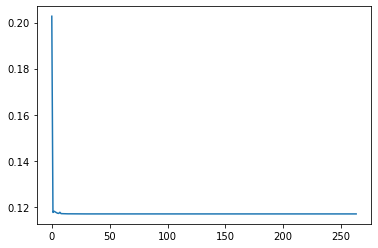

In [71]:
plt.plot(track_loss_sag)

## SAGA

In [72]:
%%time
w = np.copy(starting_point)
track_loss_saga = [loss(data, w, targets)]
start =  time.time()
track_time_saga = [0]
track_w_saga = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SAGA"]
decay = LEARNING_RATE_DECAY["SAGA"]

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            g = np.array([grad_single(c_data[i], w, c_targets[i]) for i in range(c_data.shape[0])])
            for _ in range(ITERS_PER_BATCH):
                index = np.random.randint(0, c_data.shape[0])
                gradient = grad_single(c_data[index], w, c_targets[index])
                w = w - step * (np.mean(g, axis=0)  - g[index] + gradient)
                g[index] = gradient
                step *= decay

                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_saga.append(w)
        track_time_saga.append(time.time() - start)
        track_loss_saga.append(loss(data, w, targets))

CPU times: user 2min 12s, sys: 6min 27s, total: 8min 39s
Wall time: 1min


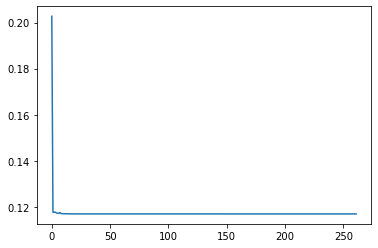

In [73]:
plt.plot(track_loss_saga)

## SVGR

In [74]:
%%time
w = np.copy(starting_point)
track_loss_svrg = [loss(data, w, targets)]
start =  time.time()
track_time_svrg = [0]
track_w_svrg = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SVGR"]
decay = LEARNING_RATE_DECAY["SVGR"]
track_angle_svrg = []
grad_prev = None
track_all_w_svrg=[starting_point]
track_grad_svrg=[]

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for i, (c_data, c_targets) in enumerate(zip(chunked_data, chunked_target)):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                w_tilde = np.copy(w)
                avg_gradients = grad_array(c_data, w, c_targets)
                for j in range(c_data.shape[0] // 16):
                    index = np.random.randint(0, c_data.shape[0])
                    grad = (grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_tilde, c_targets[index]) +
                            avg_gradients)
                    w = w - step * grad

                if grad_prev is not None:
                    track_angle_svrg.append(angle_between(grad,grad_prev))
                grad_prev = grad
                step *= decay
                track_grad_svrg.append(grad)
                track_all_w_svrg.append(w)
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_svrg.append(w)
        track_time_svrg.append(time.time() - start)
        track_loss_svrg.append(loss(data, w, targets))

CPU times: user 7min 29s, sys: 1min 14s, total: 8min 43s
Wall time: 1min


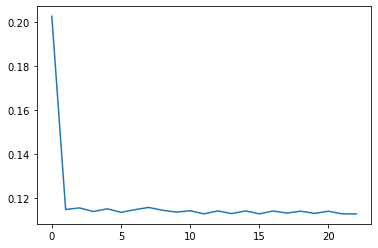

In [75]:
plt.plot(track_loss_svrg)

## SARAH

In [76]:
%%time
w = np.copy(starting_point)
track_loss_sarah = [loss(data, w, targets)]
start =  time.time()
track_time_sarah = [0]
track_w_sarah = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SARAH"]
decay = LEARNING_RATE_DECAY["SARAH"]
track_grad_sarah = []

grad_prev = None
track_angle_sarah = []
track_all_w_sarah = [starting_point]

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                w_0 = np.copy(w)
                v_0 = grad_array(c_data, w, c_targets)
                w = w_0 - step * v_0
                for t in range(np.random.randint(0, c_data.shape[0] // 16)):
                    index = np.random.randint(0, c_data.shape[0])
                    v_0 = (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_0, c_targets[index]) +
                            v_0
                    )
                    w_0 = np.copy(w)
                    w = w - step * v_0

                if grad_prev is not None:
                    track_angle_sarah.append(angle_between(v_0,grad_prev))
                grad_prev = v_0
                track_all_w_sarah.append(w)
                track_grad_sarah.append(v_0)

                step *= decay
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sarah.append(w)
        track_time_sarah.append(time.time() - start)
        track_loss_sarah.append(loss(data, w, targets))

CPU times: user 6min 53s, sys: 1min 39s, total: 8min 32s
Wall time: 1min


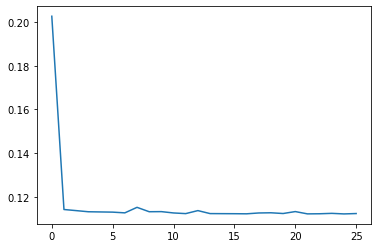

In [77]:
plt.plot(track_loss_sarah)

## SARAH+

In [78]:
%%time
w = np.copy(starting_point)
track_loss_sarah_plus = [loss(data, w, targets)]
start =  time.time()
track_time_sarah_plus = [0]
track_w_sarah_plus = [w]
time_counter = time.time()
step = STEP_SIZES[DATASET][LOSS]["SARAH+"]
decay = LEARNING_RATE_DECAY["SARAH+"]

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                w_0 = np.copy(w)
                v_0 = grad_array(c_data, w, c_targets)
                w = w_0 - step * v_0
                v_t = np.copy(v_0)
                for t in range(c_data.shape[0] // 16):
                    if np.linalg.norm(v_t)**2 < 1/8 * (np.linalg.norm(v_0) ** 2):
                        break
                    index = np.random.randint(0, c_data.shape[0])
                    v_t = (
                            grad_single(c_data[index], w, c_targets[index]) -
                            grad_single(c_data[index], w_0, c_targets[index]) +
                            v_t
                    )
                    w_0 = np.copy(w)
                    w = w - step * v_t

                step *= decay
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_sarah_plus.append(w)
        track_time_sarah_plus.append(time.time() - start)
        track_loss_sarah_plus.append(loss(data, w, targets))

CPU times: user 7min 9s, sys: 1min 29s, total: 8min 39s
Wall time: 1min


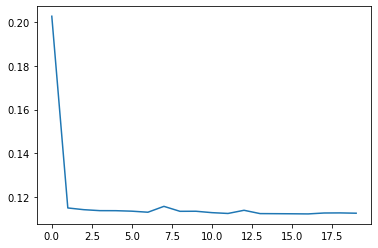

In [79]:
plt.plot(track_loss_sarah_plus)

## SpiderBoost

In [80]:
%%time
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_loss_spider_boost = [loss(data, w, targets)]
track_time_spider_boost = [0]
track_w_spider_boost = [w]
time_counter = time.time()

start =  time.time()
step = STEP_SIZES[DATASET][LOSS]["SpiderBoost"]
decay = LEARNING_RATE_DECAY["SpiderBoost"]
track_all_w_spider_boost = [starting_point]
track_grad_spider_boost = []

track_angle_spider_boost = []
grad_prev = None
for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            all_indexes = list(range(c_data.shape[0]))
            v_previous = grad_array(c_data, w, c_targets)
            for i in range(ITERS_PER_BATCH):
                q = int(math.sqrt(c_data.shape[0]))
                if  i % q == 0:
                    vk = grad_array(c_data, w, c_targets)
                else:
                    sample_indexes = np.random.choice(all_indexes, q)
                    samples_data = c_data[sample_indexes]
                    samples_targets = c_targets[sample_indexes]

                    first = grad_array(samples_data, w, samples_targets)
                    second = grad_array(samples_data, w_previous, samples_targets)
                    vk = (first - second) + v_previous


                w_previous = np.copy(w)
                v_previous = np.copy(vk)

                if grad_prev is not None:
                    track_angle_spider_boost.append(angle_between(vk,grad_prev))
                grad_prev = vk
                track_all_w_spider_boost.append(w)
                track_grad_spider_boost.append(vk)
                w = w - step * vk


                step *= decay
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_spider_boost.append(w)
        track_time_spider_boost.append(time.time() - start)
        track_loss_spider_boost.append(loss(data, w, targets))

CPU times: user 6min 34s, sys: 1min 59s, total: 8min 34s
Wall time: 1min


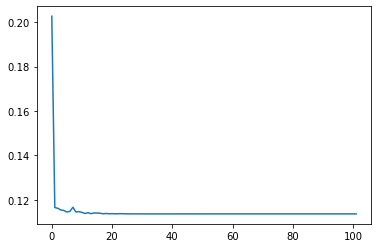

In [81]:
plt.plot(track_loss_spider_boost)

## SNVRG

In [82]:
def updateReferencePoints(wl_old, w, r, K):
    wl_new  = []
    for l in range(r):
        wl_new.append(wl_old[l])
    for l in range(r, K+1):
        wl_new.append(w)
    return np.array(wl_new)

def updateReferenceGradients(gl_old, wl_new, r, K, Bl, data, targets):
    gl_new  = []
    for l in range(r):
        gl_new.append(gl_old[l])
    for l in range(r, K+1):
        indexes = np.random.choice(list(range(data.shape[0])), Bl[l], replace=False)
        gl_new.append(grad_array(data[indexes], wl_new[l], targets[indexes]) -
                      grad_array(data[indexes], wl_new[l-1], targets[indexes]))
    return gl_new
rs = []
def oneEpochSNVRG(w, M, data, targets):
    w = np.copy(w)
    K = 2
    B = 256
    b = 2
    Bl = np.array([B/(b**(i+1)) for i in range(K+1)]).astype("int")
    Tl = np.array([b for _ in range(K+1)])
    wl = np.array([w for _ in range(K+1)])
    wl_history = [[w for _ in range(K+1)]]
    gl = np.array([np.zeros(np.shape(w)).tolist() for _ in range(K+1)])
    indexes = np.random.choice(list(range(data.shape[0])), B, replace=False)
    gl[0] = grad_array(data[indexes], w, targets[indexes])
    v = np.sum(gl, axis=0)
    w = w - 1/(10 * M) * v
    wl_history.append(np.copy(w))
    for t in range(1, np.prod(Tl) - 1):

        for j in range( K + 1):
            if t % np.prod(Tl[j+1:]) == 0:
                r = j
                break
        r = max(1, r)
        rs.append(r)

        wl = updateReferencePoints(wl, w, r, K)
        gl = updateReferenceGradients(gl, wl, r, K, Bl, data, targets)

        v = np.sum(gl, axis=0)

        w = w - 1/(10 * M) * v
        wl_history.append(np.copy(w))

    return wl_history[np.random.randint(wl.shape[0] - 1)], w, v

In [83]:
%%time
w = np.copy(starting_point)
w_previous = np.zeros(data.shape[1])

track_loss_snvrg = [loss(data, w, targets)]
track_time_snvrg = [0]
track_w_snvrg = [w]
time_counter = time.time()
start =  time.time()
M = STEP_SIZES[DATASET][LOSS]["SNVRG"]
decay = LEARNING_RATE_DECAY["SNVRG"]

track_all_w_snvrg = [starting_point]
track_angle_snvrg = []
grad_prev = None
track_grad_snvrg = []

for i in range(EPOCHS):
    if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
    for j in range(2):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        if SAME_MINI_BATCH: np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for c_data, c_targets in zip(chunked_data, chunked_target):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            for _ in range(ITERS_PER_BATCH):
                y_s, w, grad = oneEpochSNVRG(w, M, c_data, c_targets)

                if grad_prev is not None:
                    track_angle_snvrg.append(angle_between(grad,grad_prev))
                grad_prev = np.copy(grad)
                track_all_w_snvrg.append(w)
                track_grad_snvrg.append(grad)

                M /= decay
                if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                    time_counter = time.time()
                    track_w_snvrg.append(w)
        track_time_snvrg.append(time.time() - start)
        track_loss_snvrg.append(loss(data, w, targets))

CPU times: user 6min 25s, sys: 2min 10s, total: 8min 36s
Wall time: 1min


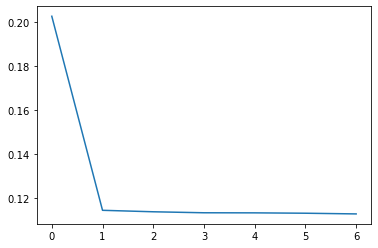

In [84]:
plt.plot(track_loss_snvrg)

In [32]:
%%time
# PL implementation
if False:
    w = np.copy(starting_point)
    w_previous = np.zeros(data.shape[1])

    track_loss_snvrg_pl = [loss(data, w, targets)]
    track_time_snvrg_pl = [0]
    track_w_snvrg_pl = [w]
    time_counter = time.time()
    start =  time.time()
    M = STEP_SIZES[DATASET][LOSS]["SNVRG"]
    decay = LEARNING_RATE_DECAY["SNVRG"]

    for i in range(EPOCHS):
        if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
        for _ in range(2):
            if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
            chunked_data, chunked_target = getMiniBatch()
            for c_data, c_targets in zip(chunked_data, chunked_target):
                if MAX_RUNTIME and MAX_RUNTIME < time.time() - start: break
                for _ in range(ITERS_PER_BATCH // 10):
                    for _ in range(np.random.randint(0, ITERS_PER_BATCH)):
                        y_s, w = oneEpochSNVRG(w, M, c_data, c_targets)

                        M /= decay
                        if (time.time() - time_counter) > MAX_RUNTIME / FRAME_ANIMATION :
                            time_counter = time.time()
                            track_w_snvrg_pl.append(w)
            track_time_snvrg_pl.append(time.time() - start)
            track_loss_snvrg_pl.append(loss(data, w, targets))

CPU times: user 2 µs, sys: 10 µs, total: 12 µs
Wall time: 5.72 µs


## Plots

In [85]:
track_time_sgd = np.array(track_time_sgd)
track_time_sag = np.array(track_time_sag)
track_time_saga = np.array(track_time_saga)
track_time_sarah = np.array(track_time_sarah)
track_time_sarah_plus = np.array(track_time_sarah_plus)
track_time_spider_boost = np.array(track_time_spider_boost)
track_time_svrg = np.array(track_time_svrg)
track_time_snvrg = np.array(track_time_snvrg)


track_loss_sgd = np.array(track_loss_sgd)
track_loss_sag = np.array(track_loss_sag)
track_loss_saga = np.array(track_loss_saga)
track_loss_sarah = np.array(track_loss_sarah)
track_loss_sarah_plus = np.array(track_loss_sarah_plus)
track_loss_spider_boost = np.array(track_loss_spider_boost)
track_loss_svrg = np.array(track_loss_svrg)
track_loss_snvrg = np.array(track_loss_snvrg)

In [86]:
# In case we want plots using time, we consider only the updates in the MAX-TIME interval
if PLOT_TIME:
    track_loss_sgd = track_loss_sgd[track_time_sgd < MAX_RUNTIME]
    track_loss_sag = track_loss_sag[track_time_sag < MAX_RUNTIME]
    track_loss_saga = track_loss_saga[track_time_saga < MAX_RUNTIME]
    track_loss_sarah = track_loss_sarah[track_time_sarah < MAX_RUNTIME]
    track_loss_sarah_plus = track_loss_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
    track_loss_spider_boost = track_loss_spider_boost[track_time_spider_boost < MAX_RUNTIME]
    track_loss_svrg = track_loss_svrg[track_time_svrg < MAX_RUNTIME]
    track_loss_snvrg = track_loss_snvrg[track_time_snvrg < MAX_RUNTIME]

    track_time_sgd = track_time_sgd[track_time_sgd < MAX_RUNTIME]
    track_time_sag = track_time_sag[track_time_sag < MAX_RUNTIME]
    track_time_saga = track_time_saga[track_time_saga < MAX_RUNTIME]
    track_time_sarah = track_time_sarah[track_time_sarah < MAX_RUNTIME]
    track_time_sarah_plus = track_time_sarah_plus[track_time_sarah_plus < MAX_RUNTIME]
    track_time_spider_boost = track_time_spider_boost[track_time_spider_boost < MAX_RUNTIME]
    track_time_svrg = track_time_svrg[track_time_svrg < MAX_RUNTIME]
    track_time_snvrg = track_time_snvrg[track_time_snvrg < MAX_RUNTIME]

In [87]:
min = np.min(
    np.concatenate((
        track_loss_sarah,
        track_loss_sarah_plus,
        track_loss_snvrg,
        track_loss_sag,
        track_loss_saga,
        track_loss_snvrg,
        track_loss_spider_boost,
        track_loss_sgd,
    ))
)

In [88]:
# Finding the best guess of F(x*)
min = np.min((min, MIN))

### Iterations

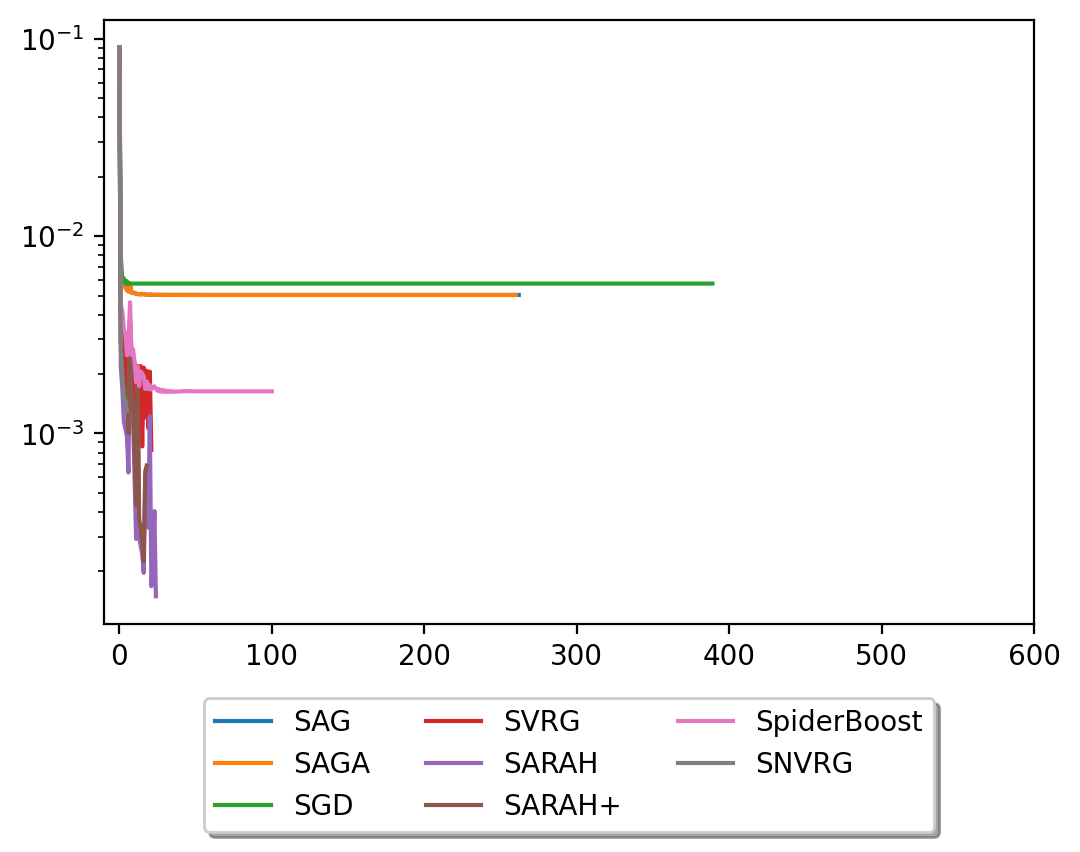

In [89]:
plt.figure(dpi=DPI_PLOTS)
plt.xlim(-10,600)
plt.semilogy(track_loss_sag - min)
plt.semilogy(track_loss_saga - min)
plt.semilogy(track_loss_sgd - min)
plt.semilogy(track_loss_svrg - min)
plt.semilogy(track_loss_sarah - min)
plt.semilogy(track_loss_sarah_plus - min)
plt.semilogy(track_loss_spider_boost - min)
plt.semilogy(track_loss_snvrg - min)

plt.legend([ "SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

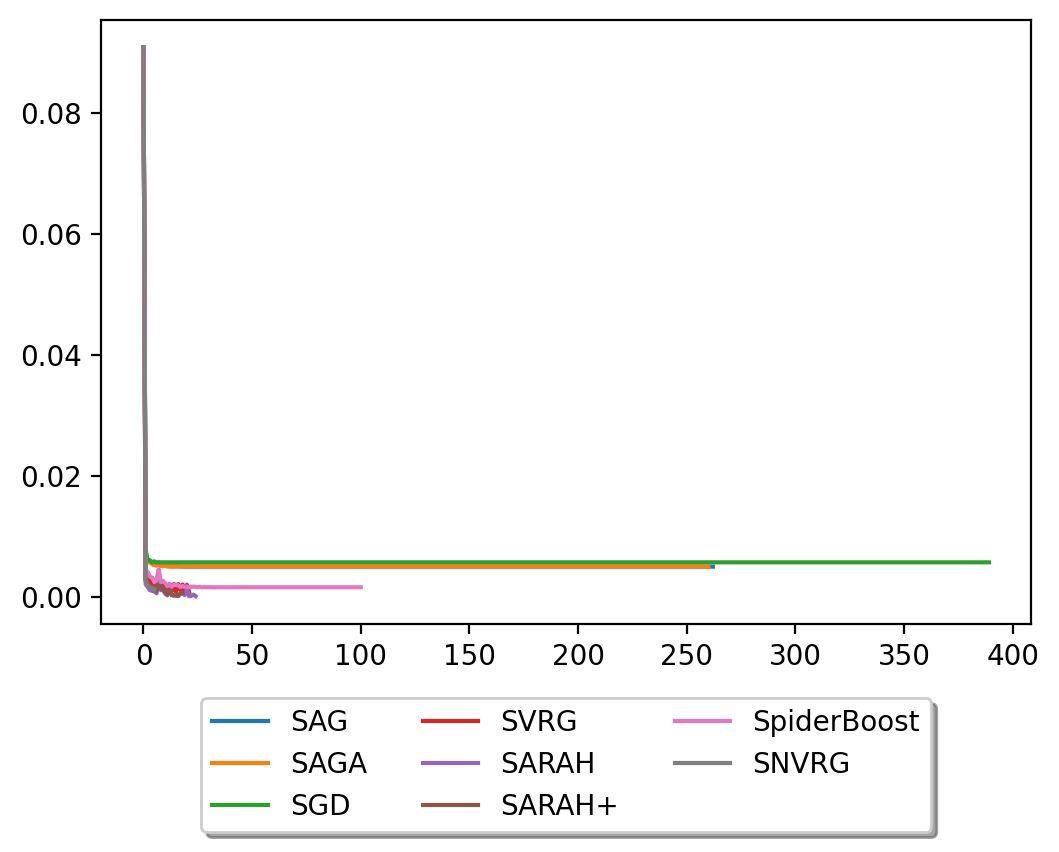

In [90]:
#robust_lin_reg_residual_log
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_loss_sag - min)
plt.plot(track_loss_saga - min)
plt.plot(track_loss_sgd - min)
plt.plot(track_loss_svrg - min)
plt.plot(track_loss_sarah - min)
plt.plot(track_loss_sarah_plus - min)
plt.plot(track_loss_spider_boost - min)
plt.plot(track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Time

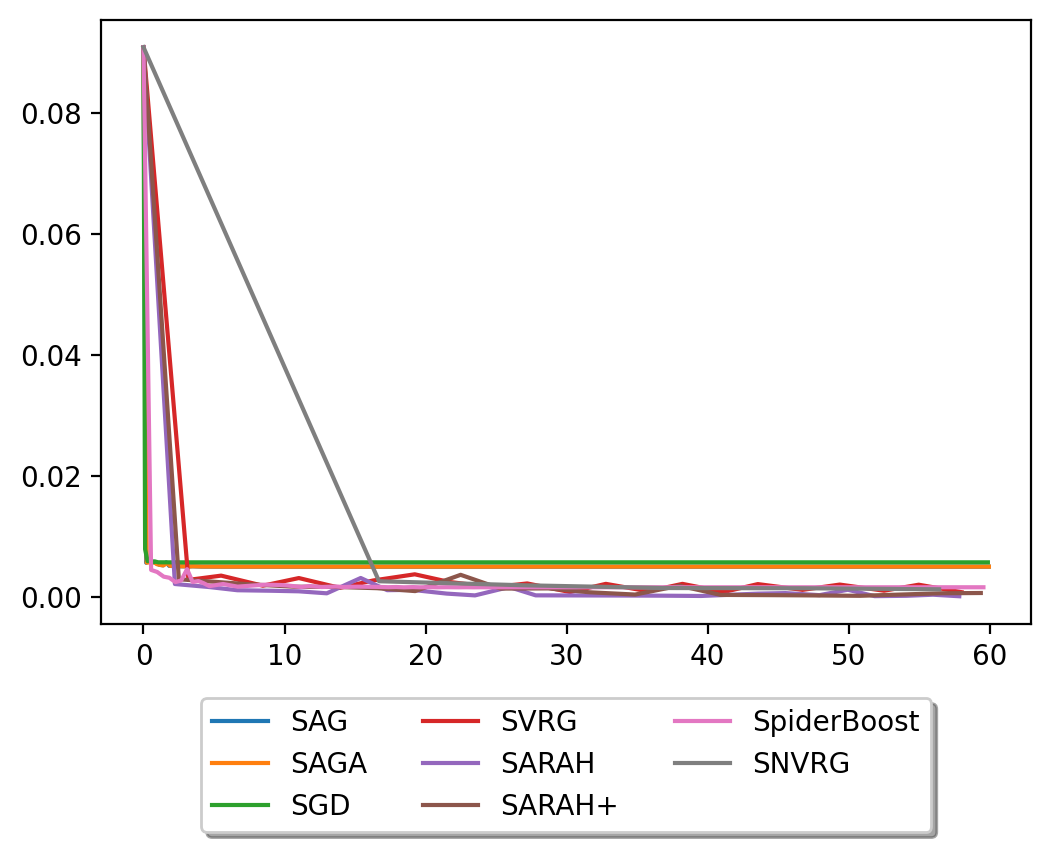

In [91]:
plt.figure(dpi=DPI_PLOTS)
plt.plot(track_time_sag, track_loss_sag - min)
plt.plot(track_time_saga, track_loss_saga - min)
plt.plot(track_time_sgd, track_loss_sgd - min)
plt.plot(track_time_svrg, track_loss_svrg - min)
plt.plot(track_time_sarah, track_loss_sarah - min)
plt.plot(track_time_sarah_plus, track_loss_sarah_plus - min)
plt.plot(track_time_spider_boost, track_loss_spider_boost - min)
plt.plot(track_time_snvrg, track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

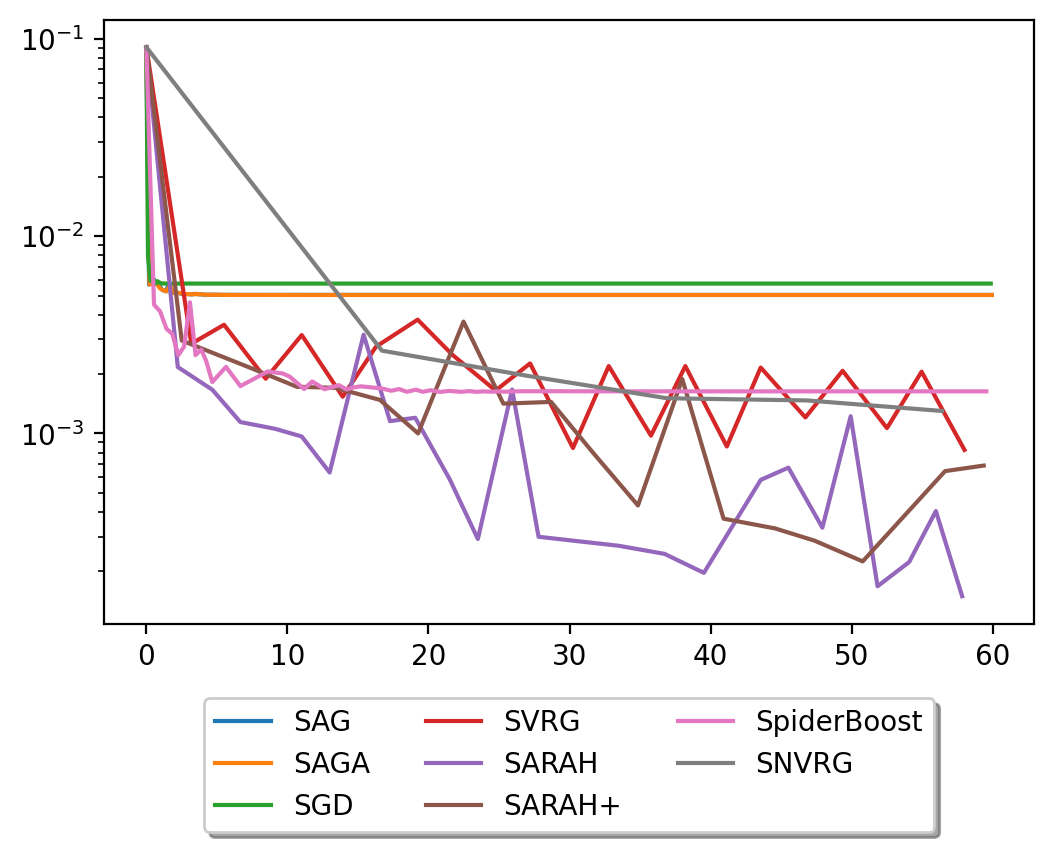

In [92]:
plt.figure(dpi=DPI_PLOTS)
plt.semilogy(track_time_sag, track_loss_sag - min)
plt.semilogy(track_time_saga, track_loss_saga - min)
plt.semilogy(track_time_sgd, track_loss_sgd - min)
plt.semilogy(track_time_svrg, track_loss_svrg - min)
plt.semilogy(track_time_sarah, track_loss_sarah - min)
plt.semilogy(track_time_sarah_plus, track_loss_sarah_plus - min)
plt.semilogy(track_time_spider_boost, track_loss_spider_boost - min)
plt.semilogy(track_time_snvrg, track_loss_snvrg - min)

plt.legend(["SAG", "SAGA", "SGD", "SVRG", "SARAH", "SARAH+", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.1),
           fancybox=True, shadow=True, ncol=3)

### Angle between gradients

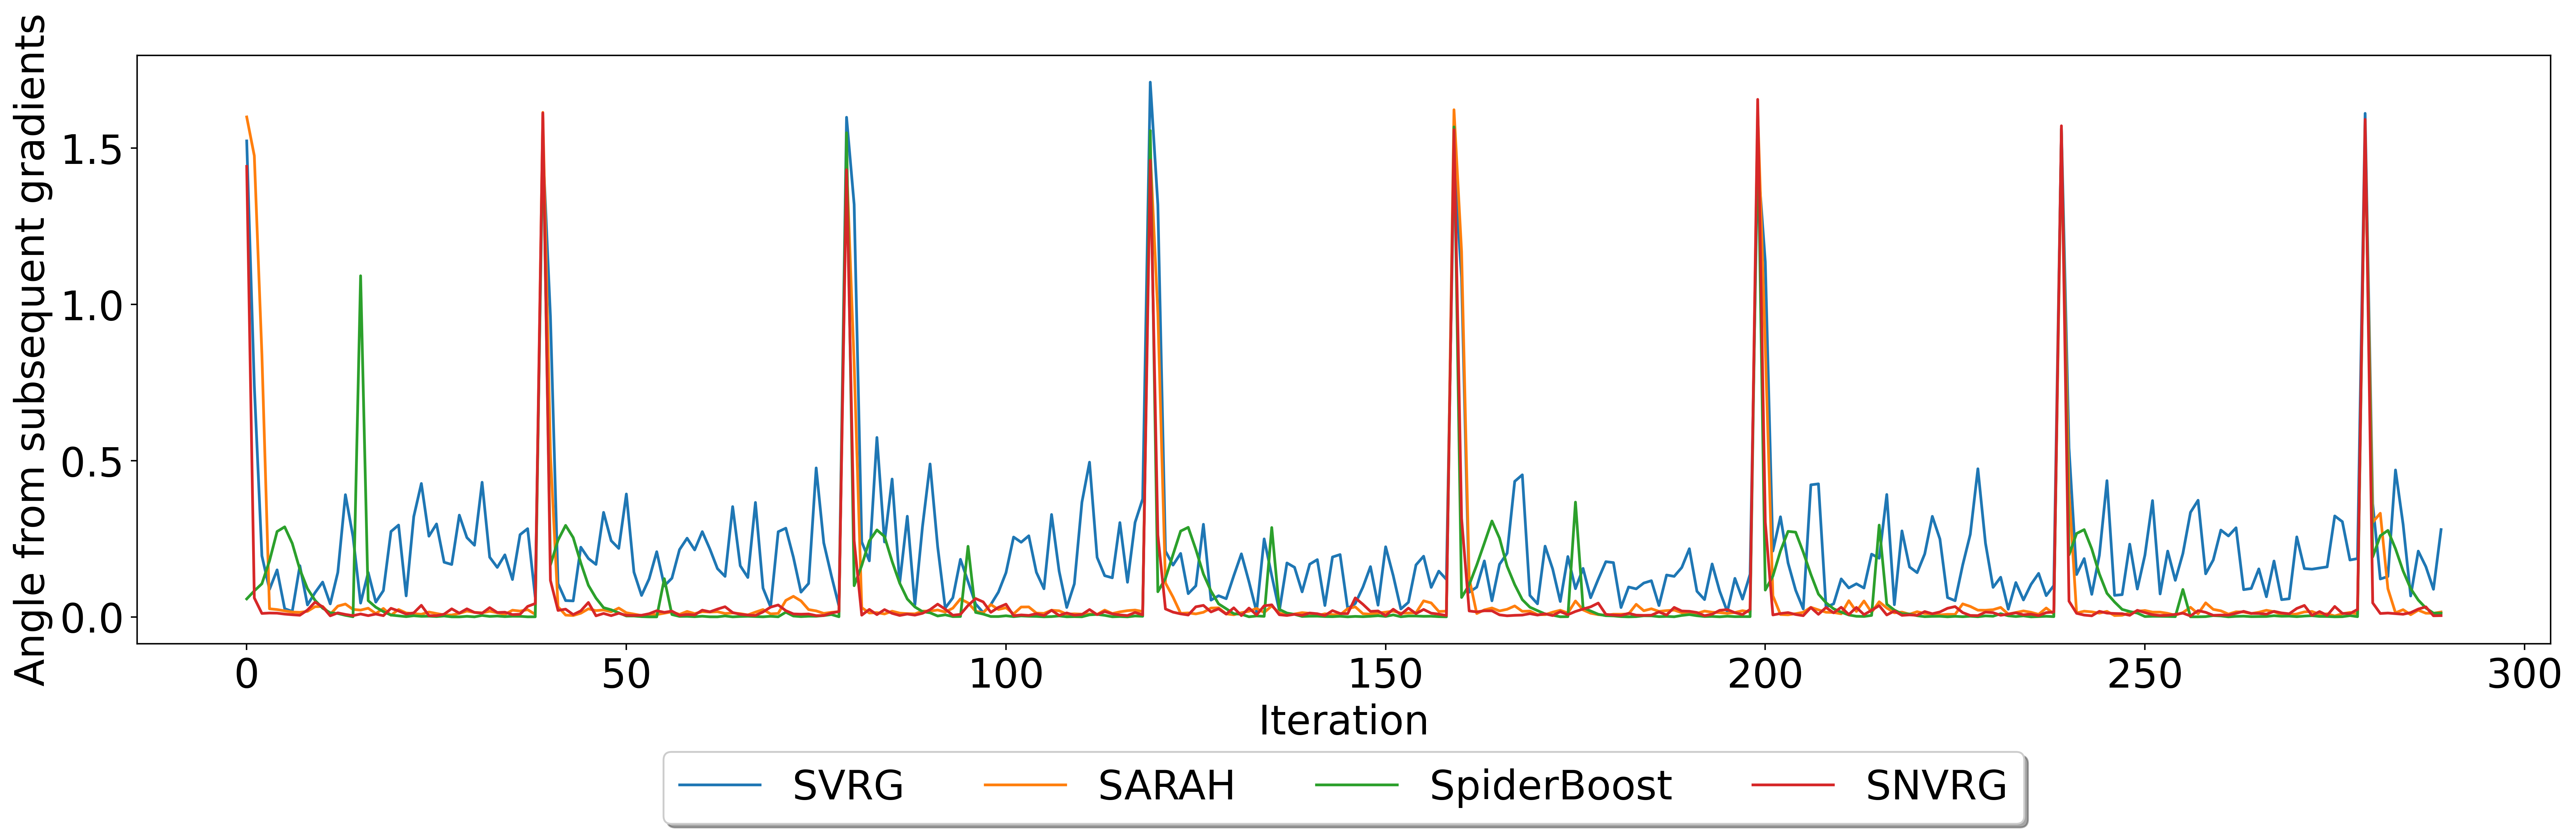

In [93]:
plt.figure(figsize=(60/2.54, 15/2.54), dpi=400)
#plt.ylim(0, 0.05)
plt.rcParams.update({'font.size': 22})
N = 290
#plt.plot(track_angle_sgd[:N])
plt.plot(track_angle_svrg[:N])
plt.plot(track_angle_sarah[:N])
plt.plot(track_angle_spider_boost[:N])
plt.plot(track_angle_snvrg[:N])
plt.xlabel("Iteration")
plt.ylabel("Angle from subsequent gradients")

plt.legend(["SVRG", "SARAH", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)
plt.show()
plt.rcParams.update({'font.size': 10})

### Gradient error

In [94]:
%%time
TO = 480
MEAN_EACH = 4
real_grad_sgd_error = []
real_grad_svrg_error = []
real_grad_sarah_error = []
real_grad_spider_boost_error = []
real_grad_snvrg_error = []
flag = False
for i in range(EPOCHS):
    if flag: break
    for j in range(2):
        if flag: break
        np.random.seed(i * 2 + j)
        chunked_data, chunked_target = getMiniBatch()
        for n, (c_data, c_targets) in enumerate(zip(chunked_data, chunked_target)):
            if flag: break
            for iter in range(ITERS_PER_BATCH):
                if flag: break
                index = (
                        i * 2 * len(chunked_target) * ITERS_PER_BATCH +
                        j * len(chunked_target) * ITERS_PER_BATCH +
                        n * ITERS_PER_BATCH +
                        iter
                )
                if index == TO:
                    flag = True
                    break
                real_grad_sgd_error.append(
                    np.linalg.norm(
                        unit_vector(grad_array(c_data, track_all_w_sgd[index], c_targets)) -
                        unit_vector(track_grad_sgd[index]))
                )
                real_grad_svrg_error.append(
                    np.linalg.norm(unit_vector(grad_array(c_data, track_all_w_svrg[index], c_targets)) - unit_vector(track_grad_svrg[index]))
                )
                real_grad_sarah_error.append(
                    np.linalg.norm(unit_vector(grad_array(c_data, track_all_w_sarah[index], c_targets)) - unit_vector(track_grad_sarah[index]))
                )
                real_grad_spider_boost_error.append(
                    np.linalg.norm(unit_vector(grad_array(c_data, track_all_w_spider_boost[index], c_targets)) - unit_vector(track_grad_spider_boost[index]))
                )
                real_grad_snvrg_error.append(
                    np.linalg.norm(unit_vector(grad_array(c_data, track_all_w_snvrg[index], c_targets)) - unit_vector(track_grad_snvrg[index]))
                )

real_grad_sgd_error = np.array(real_grad_sgd_error).reshape((MEAN_EACH, -1)).mean(axis=0)
real_grad_svrg_error = np.array(real_grad_svrg_error).reshape((MEAN_EACH, -1)).mean(axis=0)
tmp = real_grad_svrg_error[::(ITERS_PER_BATCH//MEAN_EACH)]
tmp[:] = 0
real_grad_sarah_error = np.array(real_grad_sarah_error).reshape((MEAN_EACH, -1)).mean(axis=0)
tmp = real_grad_sarah_error[::(ITERS_PER_BATCH//MEAN_EACH)]
tmp[:] = 0
real_grad_spider_boost_error = np.array(real_grad_spider_boost_error).reshape((MEAN_EACH, -1)).mean(axis=0)
real_grad_snvrg_error = np.array(real_grad_snvrg_error).reshape((MEAN_EACH, -1)).mean(axis=0)
tmp = real_grad_snvrg_error[::(ITERS_PER_BATCH//MEAN_EACH)]
tmp[:] = 0


CPU times: user 16.5 s, sys: 3.27 s, total: 19.7 s
Wall time: 2.42 s


In [97]:
plt.rcParams.update({'font.size': 22})

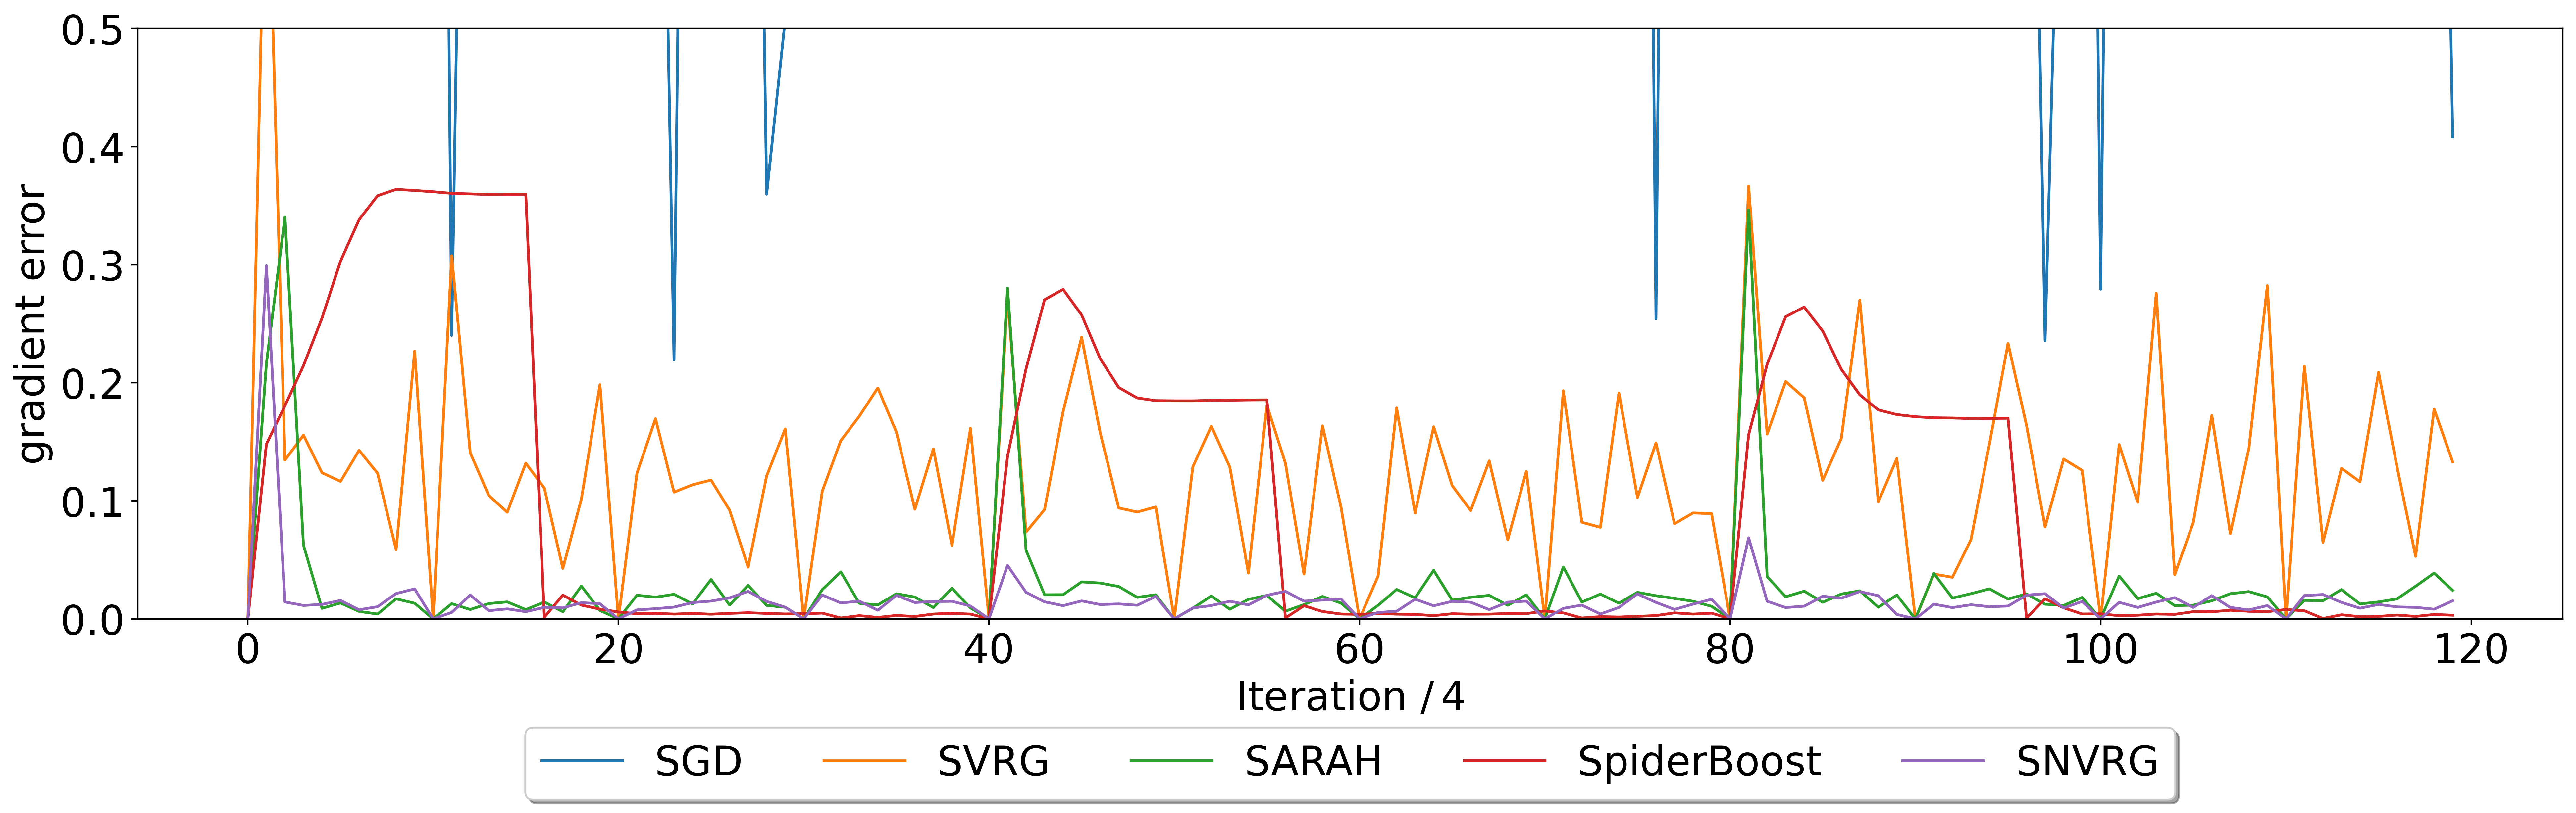

In [98]:
plt.figure(figsize=(60/2.54, 15/2.54), dpi=400)
plt.ylim(0,0.5)
plt.rcParams.update({'font.size': 22})
plt.plot(real_grad_sgd_error)
plt.plot(real_grad_svrg_error)
plt.plot(real_grad_sarah_error)
plt.plot(real_grad_spider_boost_error)
plt.plot(real_grad_snvrg_error)
plt.xlabel(f"Iteration $/ \,{MEAN_EACH}$")
plt.ylabel("gradient error")

plt.legend(["SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"], loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)
plt.show()
plt.rcParams.update({'font.size': 10})

In [122]:
mean_sgd = real_grad_sgd_error.mean()
mean_svrg = real_grad_svrg_error.mean()
mean_sarah = real_grad_sarah_error.mean()
mean_spider_boost = real_grad_spider_boost_error.mean()
mean_snvrg = real_grad_snvrg_error.mean()

print(f"""SGD: {mean_sgd:.3f}
SVRG: {mean_svrg:.3f}
SARAH: {mean_sarah:.3f}
SpiderBoost: {mean_spider_boost:.3f}
SNVRG: {mean_snvrg:.3f}""")

SGD: 1.129
SVRG: 0.125
SARAH: 0.027
SpiderBoost: 0.092
SNVRG: 0.015


In [117]:
points.shape

(1, 1000, 2)

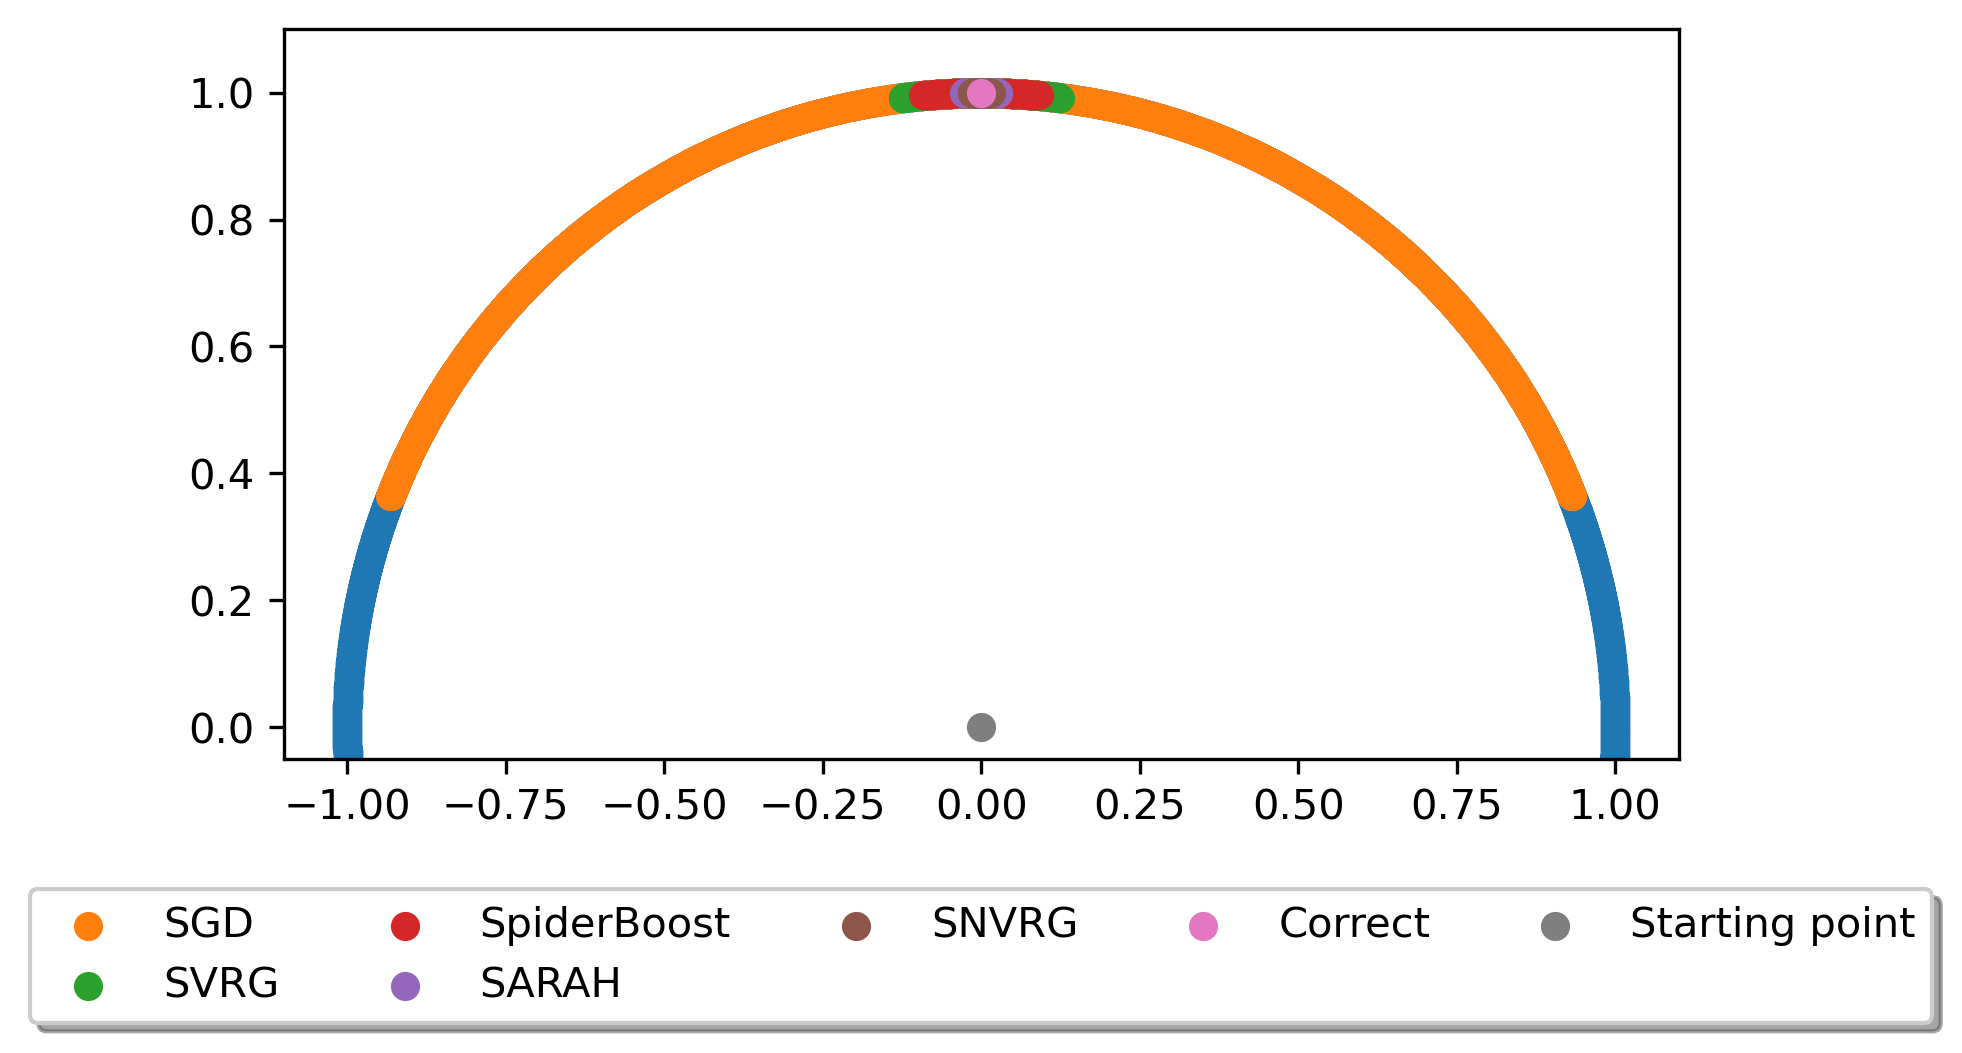

In [140]:
import numpy as np
import matplotlib.pyplot as plt

def circle_points(r, n):
    t = np.linspace(0, 2*np.pi, n, endpoint=False)
    x = r * np.cos(t)
    y = r * np.sin(t)
    return np.c_[x, y]

points = np.array(circle_points(1, 10000))

fig, ax = plt.subplots(dpi=300)
ax.set_aspect('equal')
ax.scatter(points[:,0], points[:,1], label='_nolegend_')

for mean in [mean_sgd, mean_svrg, mean_spider_boost, mean_sarah, mean_snvrg]:
    p_in_error = np.array([point for point in points if np.linalg.norm(point - np.array([0,1])) < mean])
    ax.scatter(p_in_error[:,0], p_in_error[:,1])
ax.set_ylim(-0.05,1.1)
ax.scatter([0], [1])
ax.scatter([0], [0])
plt.legend(["SGD", "SVRG", "SpiderBoost", "SARAH", "SNVRG", "Correct", "Starting point"], loc='upper center', bbox_to_anchor=(0.5, -0.15),
           fancybox=True, shadow=True, ncol=5)

### Contour plots of main algorithms

In [45]:
def generate(w, PAD=1, TITLE=""):
    w_cut = w[:10000]

    X = np.linspace(-25, 50, 100)
    Y = np.linspace(-10, 80, 100)
    Z = []
    for y in Y:
        Z.append([loss(data, np.array([x, y]), targets) for x in X])


    #Z = [loss(data, np.array([y,x]), targets) for x,y in zip(X,Y)]
    fig = go.Figure(
        data =[
        go.Contour(
            z=Z,
            x=X,
            y=Y,
            showscale=False,
        ),
        go.Scatter(
            showlegend = False,
            hoverinfo='none',
            x=np.array(w_cut)[:,0],
            y=np.array(w_cut)[:,1],
            mode='markers+lines',
            marker=dict(
                size=4,
                color="#ff4747",
                colorscale='Viridis',
            ),
            line=dict(
                color="#ff4747",
                width=2
            )
        )
    ])
    fig.update_layout(
        title={
            'text': TITLE,
            'y':0.9,
            'x':0.5,
            'xanchor': 'center',
            'yanchor': 'top'})
    fig.update_traces(ncontours=45, selector=dict(type='contour'))
    fig.update_xaxes(range=[-25, 50])
    fig.update_yaxes(range=[-10, 80])
    fig.update_layout(
        width=500,height=500,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual',
        ),
    )
    fig.show(renderer="browser")

In [46]:
if SHOW_ANIMATION and data.shape[1] == 2:
    generate(track_all_w_sgd, TITLE="SGD")
    generate(track_all_w_sarah, TITLE="SARAH")
    generate(track_all_w_snvrg, TITLE="SNVRG")
    generate(track_all_w_spider_boost, TITLE="SpiderBoost")
    generate(track_all_w_svrg, TITLE="SVRG")


## 3D plots

### Animated

In [47]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    x_range = (-30,80)
    y_range = (-30,80)
    x = np.linspace(*x_range, 50)
    y = np.linspace(*y_range, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    tracks = [
        track_w_sgd, track_w_svrg,
        track_w_sarah, track_w_spider_boost, track_w_snvrg
    ]
    names = [
        "SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"
    ]

    frames_tot = np.min([
        len(t) for t in tracks
    ])
    surface = go.Surface(
        showscale=False,
        z=Z, x=X, y=Y,
        colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
        colorbar=None
    ),

    frames = []
    for frame in range(frames_tot):
        grid = []
        #generate horizontal scatter plot:
        for idx, x_ in enumerate(x):
            grid.append(
                go.Scatter3d(
                    x=[x_] * (len(y)), y=y, z=Z[:,idx],
                    mode="lines",
                    showlegend=False,
                    line=dict(
                        color=f"rgb(200,200,200)",
                        width=2
                    )
                )
            )
        for idx, y_ in enumerate(y):
            grid.append(
                go.Scatter3d(
                    x=x, y=[y_] * (len(x)), z=Z[idx,:],
                    mode="lines",
                    showlegend=False,
                    line=dict(
                        color=f"rgb(200,200,200)",
                        width=2
                    )
                )
            )



        frame_data = grid + [
            go.Surface(
                showscale=False,
                z=Z, x=X, y=Y,
                colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
                colorbar=None
            )
        ]
        for i, (track, name) in enumerate(zip(tracks, names)):
            track = track[:frame]
            xx, yy = np.hsplit(np.array(track),2)
            zz = np.array([loss(data, w_, targets) for w_ in track])
            xx = xx.reshape(-1)
            yy = yy.reshape(-1)
            zz = zz.reshape(-1)
            color = int(i/len(tracks)*255)
            frame_data.append(
                go.Scatter3d(
                    name=name,
                    x=xx, y=yy, z=zz,
                    marker=dict(
                        size=4,
                        color=f"hsl({color}, 100%, 50%)",
                        colorscale='Viridis',
                    ),
                    line=dict(
                        color=f"hsl({color}, 100%, 50%)",
                        width=2
                    )
                )
            )
        frames.append(go.Frame(data=frame_data)) #1

    fig = go.Figure(data=frames[0].data, frames=frames)

    fig.update_layout(
        width=1600,height=1000,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(args = [],
                          label = "Play",
                          method = "animate")]
        )]
    )

    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)


    fig.show(renderer="browser")
    del fig


    #USED TO FIND CAMERA
    # import plotly.graph_objects as go
    # import dash
    # import dash_core_components as dcc
    # import dash_html_components as html
    # from dash.dependencies import Input, Output
    # app = dash.Dash()
    # app.layout = html.Div([
    #     html.Div(id="output"),        # use to print current relayout values
    #     dcc.Graph(id="fig", figure=fig)
    # ])
    # @app.callback(
    #     Output("output", "children"),
    #     Input("fig", "relayoutData")
    # )
    # def show_data(data):
    #     # show camera settings like eye upon change
    #     return [str(data)]
    # app.run_server(debug=False, use_reloader=False)

### Static first N

In [48]:
import plotly.graph_objects as go
if SHOW_ANIMATION and data.shape[1] == 2:
    NUM_POINTS = 500
    FIRST_N = 1000
    x_range = (-30,80)
    y_range = (-30,80)
    x = np.linspace(*x_range, 50)
    y = np.linspace(*y_range, 50)
    X, Y = np.meshgrid(x, y)
    Z = np.array([
        [loss(data, np.array([x,y]), targets) for x,y in zip(x_r, y_r)]
        for x_r, y_r in zip(X,Y)
    ])

    tracks = [track[:FIRST_N][::int(len(track[:FIRST_N]) / 500)] for track in [
        track_all_w_sgd, track_all_w_svrg,
        track_all_w_sarah, track_all_w_spider_boost, track_all_w_snvrg
    ]]

    names = [
        "SGD", "SVRG", "SARAH", "SpiderBoost", "SNVRG"
    ]

    surface = go.Surface(
        showscale=False,
        z=Z, x=X, y=Y,
        colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
        colorbar=None
    ),

    grid = []
    #generate horizontal scatter plot:
    for idx, x_ in enumerate(x):
        grid.append(
            go.Scatter3d(
                x=[x_] * (len(y)), y=y, z=Z[:,idx],
                mode="lines",
                showlegend=False,
                line=dict(
                    color=f"rgb(200,200,200)",
                    width=2
                )
            )
        )
    for idx, y_ in enumerate(y):
        grid.append(
            go.Scatter3d(
                x=x, y=[y_] * (len(x)), z=Z[idx,:],
                mode="lines",
                showlegend=False,
                line=dict(
                    color=f"rgb(200,200,200)",
                    width=2
                )
            )
        )



    data_ = grid + [
        go.Surface(
            showscale=False,
            z=Z, x=X, y=Y,
            colorscale=[[0, 'rgba(0,0,255, 0.3)'], [1, 'rgba(255,0,0, 0.3)']],
            colorbar=None
        )
    ]
    for i, (track, name) in enumerate(zip(tracks, names)):
        xx, yy = np.hsplit(np.array(track),2)
        zz = np.array([loss(data, w_, targets) for w_ in track])
        xx = xx.reshape(-1)
        yy = yy.reshape(-1)
        zz = zz.reshape(-1)
        color = int(i/len(tracks)*255)
        data_.append(
            go.Scatter3d(
                name=name,
                x=xx, y=yy, z=zz,
                marker=dict(
                    size=4,
                    color=f"hsl({color}, 100%, 50%)",
                    colorscale='Viridis',
                ),
                line=dict(
                    color=f"hsl({color}, 100%, 50%)",
                    width=2
                )
            )
        )


    fig = go.Figure(data=data_)

    fig.update_layout(
        width=1600,height=1000,autosize=True,
        scene=dict(
            aspectratio = dict( x=1, y=1, z=1 ),
            aspectmode = 'manual'
        ),
        updatemenus=[dict(
            type="buttons",
            buttons=[dict(args = [],
                          label = "Play",
                          method = "animate")]
        )]
    )

    import json
    camera = json.loads("{'center': {'x': 0.006366696856033653, 'y': -0.05218330435246074, 'z': -0.0739852163325267}, 'eye': {'x': -0.7885156751277191, 'y': -1.1561474889685182, 'z': 0.7659138958640532}}".replace("'", '"'))
    fig.update_layout(scene_camera=camera)


    fig.show(renderer="browser")
    del fig